### DATA 620
#### Week 3 Part 1 Assignment: Simple 2 Node Network  
##### Southern Woman Dataset Analysis
### [Video Presentation](https://www.youtube.com/watch?v=uEcLGo966us)
##### Group Four
- Santosh Cheruku
- Vinicio Haro
- Javern Wilson
- Saayed Alam  

The data we will be working comes from the Davis Southern Club. We are  looking at the attendance of 14 Social events by 18 Southern Women. The data is given to us in the form of a matrix with labels where each entry in the matrix is a 1 if person $i$ attended event $j$.   

The data background can be found [here](http://vlado.fmf.uni-lj.si/pub/networks/data/ucinet/ucidata.htm#davis).

The data can be found [here](http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/davis.dat).  

We will be loading the data from the networkx package for ease of use. 

In [1]:
# package loading
import networkx as nx
import networkx.algorithms.bipartite as bp
import math
import numpy as np
from operator import itemgetter, attrgetter
import matplotlib.pyplot as plot
import matplotlib.colors as colors
import pandas as pd
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial import distance
import networkx.algorithms.bipartite as bipartite
% matplotlib inline

In [2]:
## get the graph data; imports as a bipartite graph
G = nx.davis_southern_women_graph()

### Simple EDA

Since we do not know much about this graph, we want to apporach our EDA with some guiding questions such as...

- Is the graph Connected?
- Is the graph directed?
- Is the graph bipartite?

We also want to look at other basic descriptives of the graph.

Definition of bipartite graph can be found [here](https://en.wikipedia.org/wiki/Bipartite_graph).

In [3]:
print(nx.is_connected(G))

True


In [4]:
print(nx.is_directed(G))

False


In [5]:
print(nx.is_bipartite(G))

True


In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 32
Number of edges: 89
Average degree:   5.5625


In [7]:
print(nx.diameter(G))

4


In [8]:
# degree centrality
deg = nx.degree(G)
max(dict(deg).values())

14

Our EDA shows us that we are dealing with a bipartite graph. By definition, this means that the nodes can be divided into two disjoint groups so that every node in the first group connects to one in the second group. We also found that our graph has a diameter of 4, 32 nodes, 89 edges, and an average degree of 5.5. The degree centraility is 14. Recall that degree centraility is the number of edges a node has. 

### Visualize the Network

Lets display the network and see what women attended what clubs. We will need to massage the data first in order to get it in a way where we can best visualize it. To prep the data, we will start off by assigning the the women and event labels into their own variables. We also also want to color code events and women to make our graph visually appealing.

In [10]:
women = G.graph['top']
events = G.graph['bottom']

for node in women:    
    G.node[node]["category"] = "woman" #create women category 
    
for node in events:    
    G.node[node]["category"] = "event" #create event category 
    
color_map = {"event": "skyblue", 
             "woman": "red"} #create a simple color to tell events apart from woman nodes

We next proceed to create a mapping such that when the first and last name of the women are displayed, they will appear with a new line.

In [11]:
label_map = {}

for event in events:    
    label_map[event] = event #events do not need newline fix
    
for woman in women:    
    women[women.index(woman)] = woman.replace(" ", "\n") #new line since women have first and last name format 
    label_map[woman] = woman.replace(" ", "\n")
    
G = nx.relabel_nodes(G, label_map) #new label

Proceed to plotting. 

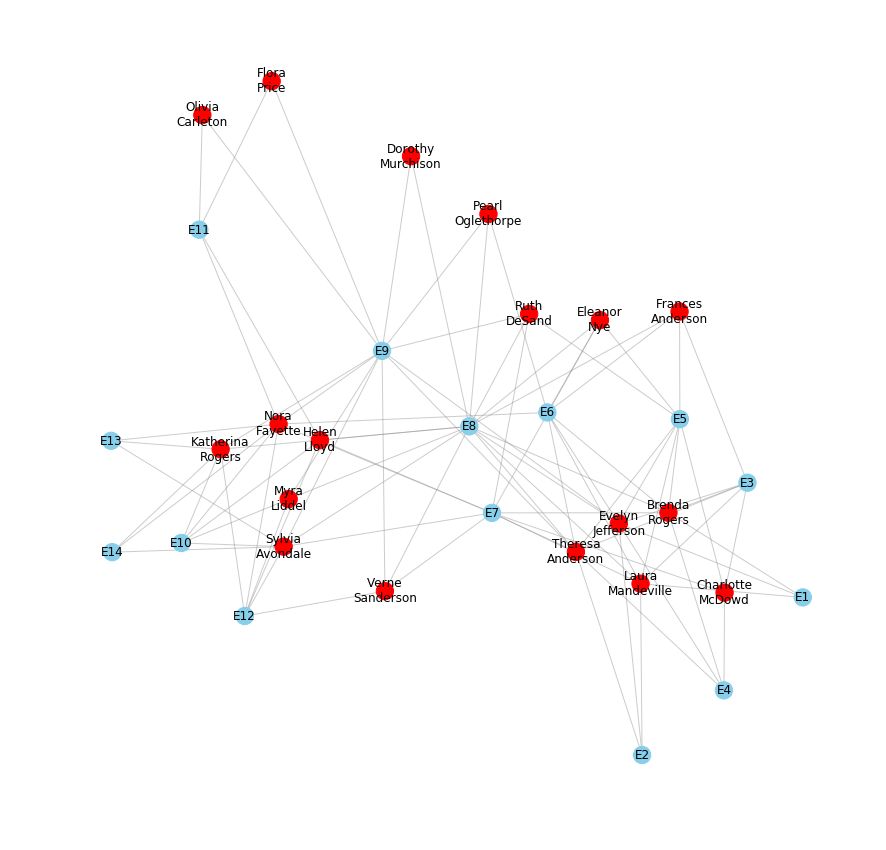

In [12]:
plot.figure(figsize = (15, 15))
pos = nx.spring_layout(G, k = 0.55,iterations = 80)
pos_labels = {}
keys = pos.keys()

for key in keys:    
    x, y = pos[key]    
    pos_labels[key] = (x, y)
    
nx.draw_networkx_labels(G, pos_labels, font_color = 'Black', font_size = 12)
nx.draw_networkx_edges(G, pos, edge_color = "Gray", alpha = 0.4)
nx.draw_networkx_nodes(G, pos, 
                       node_color = [color_map[G.node[node]['category']] for node in G], node_size = 300)

plot.axis("off")
plot.show()

The bipartite graph of the overall network displays the clubs that the women participated in. We can easily identify some clubs that have a high degree centraility such as E9. 

### Friendships & Events

We want to analyze the friendships by taking a look at a bipartite projection. We will specifically drill down to see what women attended the same event/club. First we will produce a color coded bar plot that demonstrates the number of events attended by each women. We will also use the color library from [matplotlib](https://python-graph-gallery.com/196-select-one-color-with-matplotlib/)

#### Friendships 

We want to get a better sense of which women were friends with each other. The easiest way is to look at the friendships visually. Lets create a color code for each woman and then look at the number of events attended by each of the women. we imagine that if a women attended a lot of events, then she may most likely have more friendships. 

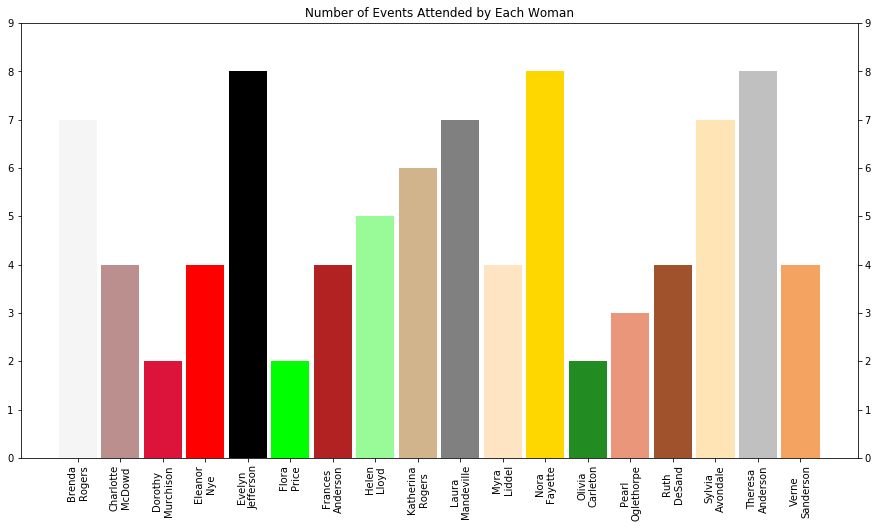

In [13]:
women_colors = {} 

for woman in women:    
    women_colors[woman] = ["black", 
                           "gray", 
                           "silver", 
                           "whitesmoke", 
                           "rosybrown", 
                           "firebrick",
                          "red", 
                           "darksalmon", 
                           "sienna", 
                           "sandybrown", 
                           "bisque", 
                           "tan",
                          "moccasin", 
                           "gold", 
                           "palegreen", 
                           "crimson", 
                           "forestgreen", 
                           "lime"][women.index(woman)] #create color key 

women_events = {}

for woman in women:    
    women_events[woman] = len(list(nx.all_neighbors(G, woman)))
    
plot.figure(figsize = (15, 8))
plot.bar(women_events.keys(), women_events.values(), 
         width = 0.9, align = "center", color = [women_colors[woman] for woman in women])

plot.xticks(rotation = 90)
plot.yticks(list(range(0, 10)))
plot.tick_params(labelright = True, right = True)
plot.title("Number of Events Attended by Each Woman")
plot.show()

From the above graph, Evelyn Jefferson, Theresa Anderson, and Nora Fayette appear to have attended the most number of events. My hypothesis is that one or all of these three women will have the highest number of friends. We define "friends" as being two nodes connected by an edge. If we look at the bipartite projection, we will have a better idea if our hypothesis proves to be true or not. 

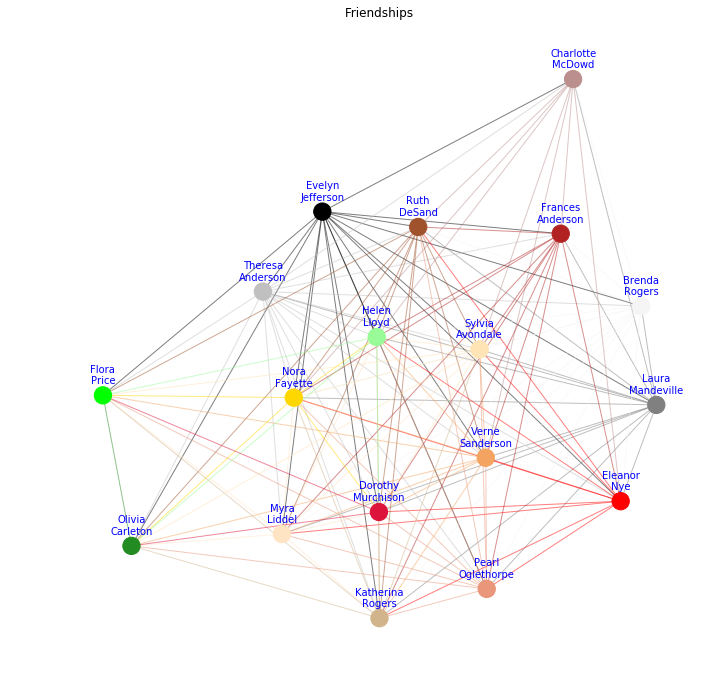

In [14]:
W = bipartite.projected_graph(G, women)

plot.figure(figsize=(12, 12))
pos = nx.spring_layout(W, k = 0.55, iterations = 80)

pos_labels = {}
keys = pos.keys()

for key in keys:    
    x, y = pos[key]    
    pos_labels[key] = (x, y+0.065)
    
nx.draw_networkx_labels(W, pos_labels, font_color = 'Blue', font_size = 10)
nx.draw_networkx_edges(W, pos, 
                       edge_color = [women_colors[edge[0]] for edge in list(W.edges())], 
                       alpha = 0.5)
nx.draw_networkx_nodes(W, pos, node_color = [women_colors[node] for node in W], node_size = 300)

plot.axis("off")
plot.title("Friendships")
plot.show()

As seen in our friendship graph, we can see evidence that someone of the women we named look like they have a high number of edges, hence many friends. The easiest way to view the distribution of friends is to simply produce another bar plot similar to the events bar plot. We can even add a weight to each edge. Each color corresponds to a weight. 

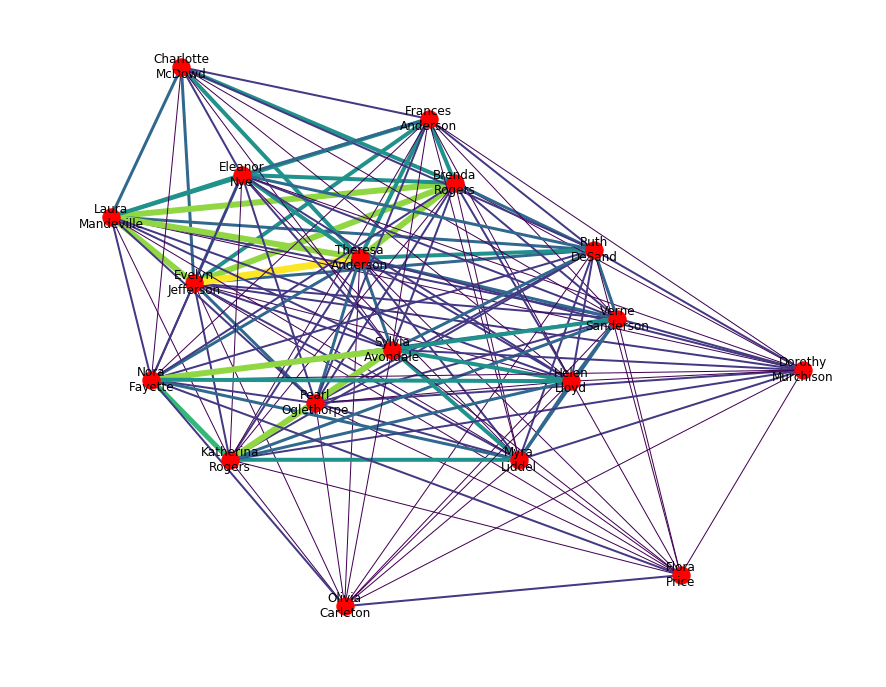

In [18]:
w = nx.project(G, women) 

wnet = bipartite.weighted_projected_graph(G, w, ratio = False)
weights = [edata['weight'] for f, t, edata in wnet.edges(data = True)]

plot.figure(figsize = (15, 12))
plot.axis("off")

nx.draw_networkx(wnet, width = weights, edge_color = weights)

#### Events

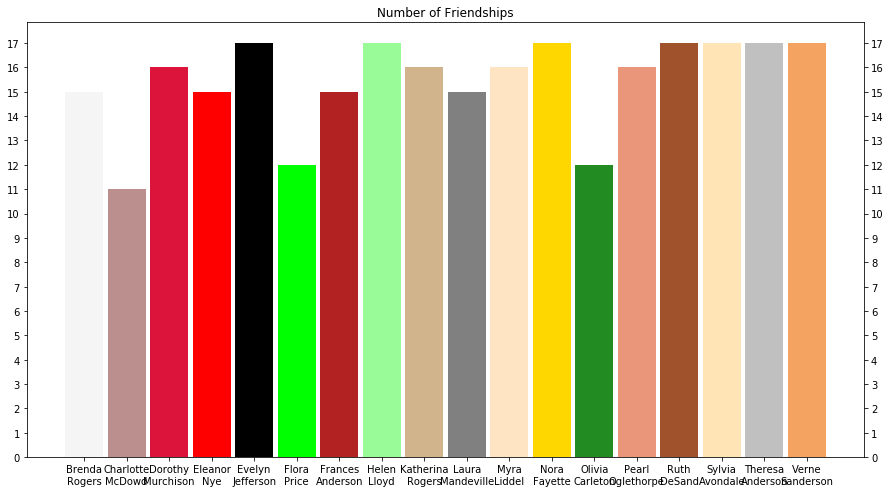

In [15]:
plot.figure(figsize = (15, 8))

friends = {}

for woman in women:    
    friends[woman] = W.degree(woman)
    
plot.bar(friends.keys(), friends.values(), 
         width = 0.9, align = "center", color = [women_colors[node] for node in W])

plot.yticks(list(range(0, 18)))
plot.tick_params(labelright = True, right = True)
plot.title("Number of Friendships")
plot.show()

We see several women who have the max number of friends which is 17. If a women would have 18 friends, it would imply that she is her own friend. We can repeat a similar visualization with a focus on the events. The events will be color coded. Lets identify the number of women at each event. 

The weighted graph is telling when it comes to showing us the extent of friendships. In fact we can see that Brenda Rogers, Laura Mandeville, Evelyn Jefferson, and Theresa Anderson.These are some of the women that attended the most number of events have the most number of connections with other women based on our graph. 

These women idnetified also had some of the higher numbers of friends compared to the other women. Is it safe to assume they were more social or the most social out of all the women shown? 

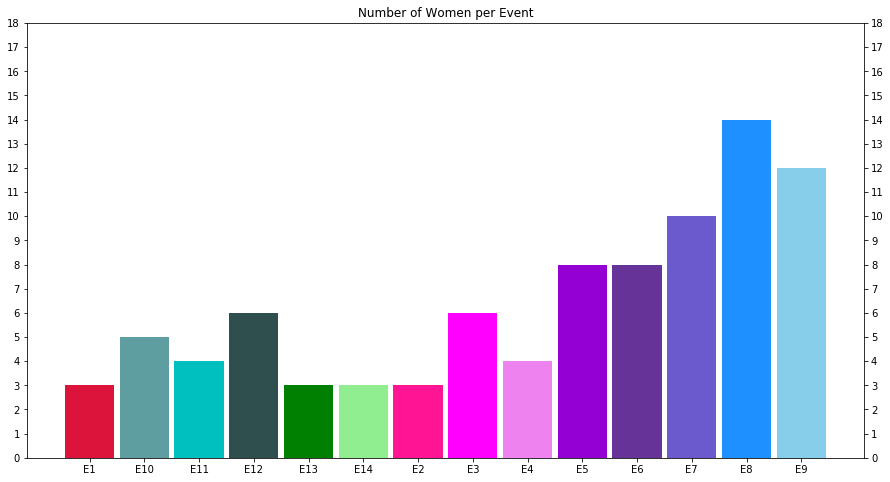

In [16]:
event_colors = {}

for event in events:    
    event_colors[event] = ["crimson",
                           "deeppink",
                           "fuchsia",
                           "violet",
                           "darkviolet",
                           "rebeccapurple",
                           "slateblue",
                           "dodgerblue",
                            "skyblue",
                           "cadetblue",
                           "c",
                           "darkslategray",
                           "g",
                           "lightgreen"][events.index(event)]
    

event_attendees = {}
    
for event in events:    
    event_attendees[event] = len(list(nx.all_neighbors(G, event)))
    
plot.figure(figsize = (15, 8))
plot.bar(event_attendees.keys(), event_attendees.values(), 
         width = 0.9, align = "center", color = [event_colors[event] for event in events])
plot.yticks(list(range(0, 19)))
plot.tick_params(labelright = True, right = True)
plot.title("Number of Women per Event")
plot.show()    

There was no event that had all the women attend. The event with the highets number of women attending was event E8 followed by E9. Lets look at the bipartite projection for events. Our hypothesis is that the most popular event will have the most edges. They are not so easily defined as friendships. One could make the speculation that an edge could be a reference to another event but of course, we do not have this level of granularity. 

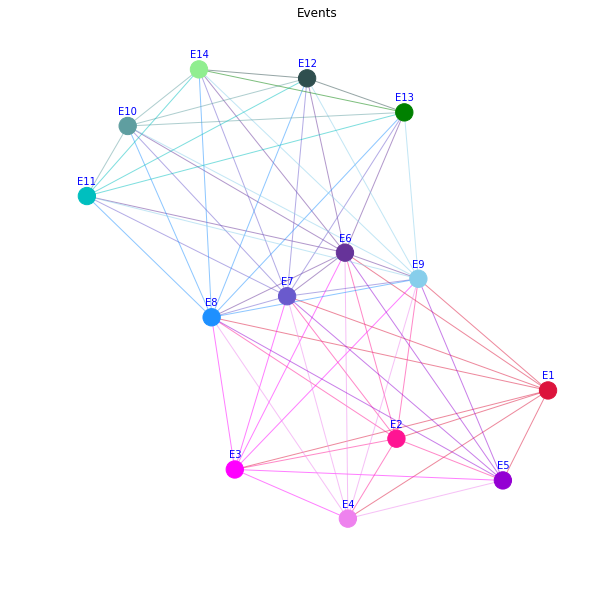

In [17]:
E = bipartite.projected_graph(G, events)

plot.figure(figsize = (10, 10))
pos = nx.spring_layout(E, k = 0.55,iterations = 80)

pos_labels = {}
keys = pos.keys()

for key in keys:    
    x, y = pos[key]    
    pos_labels[key] = (x, y+0.065)
    
nx.draw_networkx_labels(E, pos_labels, font_color = 'Blue', font_size = 10)
nx.draw_networkx_edges(E, pos, 
                       edge_color = [event_colors[edge[0]] for edge in list(E.edges())], 
                       alpha = 0.5)
nx.draw_networkx_nodes(E, pos, node_color = [event_colors[node] for node in E], node_size = 300)
plot.axis("off")
plot.title("Events")
plot.show()

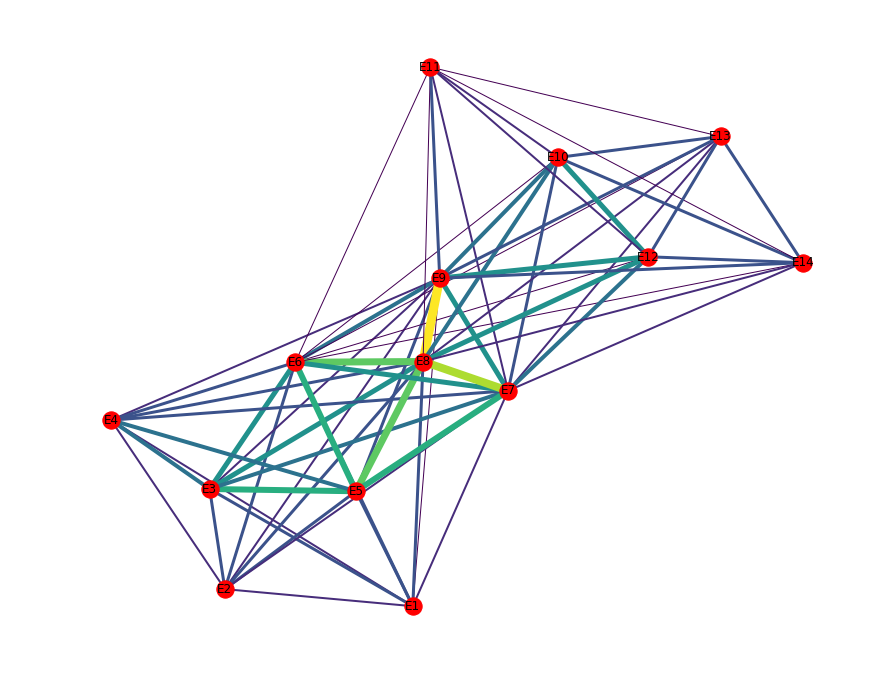

In [19]:
e = nx.project(G, events) 

wnet = bipartite.weighted_projected_graph(G, e, ratio = False)
weights = [edata['weight'] for f, t, edata in wnet.edges(data = True)]

plot.figure(figsize = (15, 12))
plot.axis("off")

nx.draw_networkx(wnet, width = weights, edge_color = weights)

We can see from the raw frequencies that event E8 was attended by the most women. When we look at our graph, we suspected this same event to have the most edges but it looked like event E9 was the most connected with other events. Connections between events is not so easily defined as connnections between people. We can only speculate that events made a reference to other events or even word of mouth contributed to the connections of events. 

The weighted graph shows that event E8 and E9 were the most important. From our frequencies plot, we know these events had the higher number of women attending.